# Plots

In [1]:
pdir <- '~/codebases/cortical_disorders2/results/RCT_diseases/plots/'
dir.create(pdir, showWarnings = F, recursive = F)
setwd(pdir)

In [2]:
load('~/codebases/cortical_disorders2/data/graphical.rda', verbose=T)

Loading objects:
  GeneAnnotation
  meta.colors
  facets


In [3]:
library(dplyr)
library(ggplot2)
library(ggpubr)

Warning message:
“package ‘dplyr’ was built under R version 4.2.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”


In [4]:
figsize <- function(x,y){
    options(repr.plot.width=x, repr.plot.height=y)
}

In [5]:
figsize(10,7)

# Data

In [6]:
RCT <- readRDS('~/codebases/cortical_disorders2/results/RCT_diseases/cisTarget_results.permuted.rds')
# RCT <- readRDS('~/codebases/cortical_disorders2/results/RCT_diseases/cisTarget_results.rds')

Warning message in readRDS("~/codebases/cortical_disorders2/results/RCT_diseases/cisTarget_results.permuted.rds"):
“cannot unserialize ALTVEC object of class 'arrow::array_string_vector' from package 'arrow'; returning length zero vector”


### Order of cores and genesets according to PeakSample

In [7]:
core.order <- GeneAnnotation[unique(RCT$regulonTbl$Core),'PeakSample', drop=F] 
core.order$PeakSampleFct <- factor(core.order$PeakSample,
                           levels=names(meta.colors[['PeakSample']]))
core.order$order <- as.numeric(core.order$PeakSampleFct)
core.order <- core.order %>% arrange(order)

In [8]:
core.levels <- rownames(core.order)

In [9]:
dis.order <- unique(RCT$regulonTbl[,c('geneSet', 'Core')]) %>%
    mutate(order=core.order[Core,'order']) %>%
    group_by(geneSet) %>% 
    summarise(avg.order=mean(order)) %>% arrange(avg.order) %>% as.data.frame()
rownames(dis.order) <- dis.order$geneSet

In [10]:
dis.levels <- dis.order$geneSet

In [11]:
core.levels
dis.levels

[1] "CHD1"     "YY1"      "SP4"      "ZNF101"   "FOXG1"    "KLF16"   
 [7] "CNOT3"    "GTF2IRD1" "GLIS3"    "VEZF1"    "EP300"    "GTF2I"   
[13] "MTF1"     "SIN3A"    "TAF1"     "SKI"      "PAX5"     "CTCF"    
[19] "ARNT2"    "GLIS1"    "EGR3"     "VDR"      "DLX2"     "MEF2C"   
[25] "KLF6"     "THRA"     "FOXO3"    "PURA"     "KLF4"

[1] "BD_2019"       "Lissencephaly" "NEUROT_2018"   "ASD"          
[5] "Hydrocephaly"  "DD"            "SCZ_2020"      "MDD_2018"     
[9] "FCDandmTOR"

In [12]:
save(list=c('core.order', 'core.levels', 'dis.order', 'dis.levels'),
     file='DiseaseCoreOrders.rda')

# Barplot of categorical with/without facets, provided colors

In [13]:
cat.barplot.regulons <- function(
    RCT,
    geneAnnotation,
    meta.colors,
    
    hide.nas = T,
    legend.loc = 'right',

    fill.var = 'PeakSample',
    fill.label = NA,
    v.facets = NA,

    geneset.fct = dis.levels,
    core.fct = core.levels,
    
    orientation='horizontal'

){
    
    all.targets <- RCT$regulonTbl %>% 
        group_by(Target) %>% 
        summarise(geneSet='Any geneset',
                  Core='Any regulon',
                  Target=Target)

    dist.df <- rbind(
        all.targets,
        RCT$regulonTbl[,colnames(all.targets)])

    # annotate targets with metadata
    dist.df <- merge(dist.df, 
                     GeneAnnotation, 
                     by.x = 'Target', all.x=T, 
                     by.y='GeneHuman', all.y=F)

    
    # Melt and set vars if facetted
    if (!is.na(v.facets)){
        dist.df <- reshape2::melt(dist.df, id.vars=c('geneSet', 'Core', 'Target'),
                                  measure.vars = facets[[v.facets]]
                                 )
        fill.var <- 'value'
        fill.col <- meta.colors[[v.facets]]
        fill.fct <- names(fill.col)
        fill.label <- if (!is.na(fill.label)) fill.label else v.facets

        v.facet <- 'variable'
        dist.df$vfacet <- factor(dist.df[, 'variable'],
                                 levels=facets[[v.facets]])

    } else {

        dist.df$vfacet <- ''
        
        fill.col <- meta.colors[[fill.var]]
        fill.fct <- names(fill.col)
        fill.label <- if (!is.na(fill.label)) fill.label else fill.var
    }

    if ((orientation == 'vertical') & ((v.facets == 'dv')|(fill.var == 'PeakSample'))){
        fill.fct <- rev(fill.fct)
    }

    # FACTORS FOR PLOT
    dist.df$fill <- factor(dist.df[, fill.var],
                           levels=fill.fct)

    dist.df$facet <- factor(dist.df[, 'geneSet'],
                            c('Any geneset', geneset.fct))

    dist.df$x.axis <- factor(dist.df[, 'Core'],
                             c('Any regulon', core.fct))

    
    # FILTER GENES WITH NO VALUE
    if (hide.nas){
        dist.df <- dist.df[!is.na(dist.df$fill),]
    }

    
    if (orientation=='horizontal'){
        ## PLOT 
        p <- ggplot(
            
            dist.df,
            # Basic axis
            aes(x=x.axis, fill=fill)) + 

            # Facets
            facet_grid(cols=vars(facet), 
                       rows=vars(vfacet),
                       scales='free_x', 
                       space='free_x',
                       switch='x') + 

            # ggpubr theme
            theme_pubr(legend = legend.loc) +
            labs_pubr() + 
    
            # Axes tuning
            scale_x_discrete(position='top') + 
            # Axis labels
            labs(x='', y='Fraction of target genes') +
            theme(
                # Rotate strips/axis labels
                strip.text.x = element_text(angle = 90, hjust=1, vjust=1),
                axis.text.x.top = element_text(angle = 90, hjust=0, vjust=0.5)
            )  
        
    } else {
        p <- ggplot(
            
            dist.df,
            # Basic axis
            aes(y=x.axis, fill=fill)) + 

            # Facets
            facet_grid(cols=vars(vfacet), 
                       rows=vars(facet),
                       scales='free_y', 
                       space='free_y',
                       switch='y') + 

            # ggpubr theme
            theme_pubr(legend = legend.loc) +
            labs_pubr() + 
    
            # Axis labels
            labs(y='', x='Fraction of target genes') +
            theme(
                # Rotate strips/axis labels
                strip.text.y.left = element_text(angle = 0, hjust=1, vjust=1),
                axis.text.x = element_text(angle = 90, hjust=1, vjust=0.5)
            )
    }
    p <- p + 

        # Add bars
        geom_bar(position = 'fill') +
        # Color of the bars
        scale_fill_manual(
            fill.label,
            values=fill.col) +
        theme(
            # Text font
            text = element_text(family='ArialMT'),
            # White background
            panel.background = element_rect(fill='white'),
            panel.grid.major = element_blank(),
            # Reduce space between bars
            panel.spacing = unit(0.2, "lines"),
            # Remove background from facets
            strip.background = element_blank(),
            # Move facets outside
            strip.placement = 'outside')

    return(p)
    
    }

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'Target'. You can override using the
`.groups` argument.


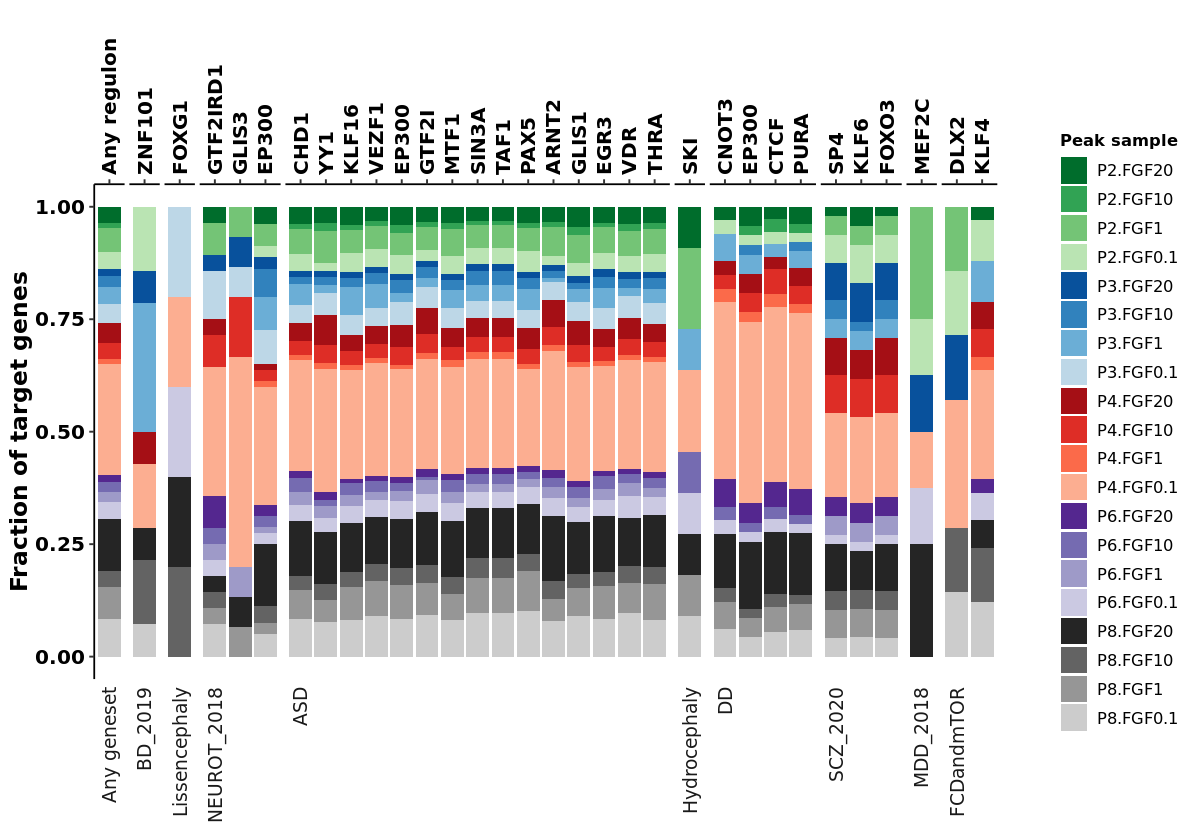

In [14]:
peak.plot <- cat.barplot.regulons(
    RCT = RCT, 
    geneAnnotation = geneAnnotation, meta.colors = meta.colors,
    fill.var = 'PeakSample',
    fill.label = 'Peak sample',
    v.facets = NA,
    # orientation='vertical'
)
peak.plot

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'Target'. You can override using the
`.groups` argument.


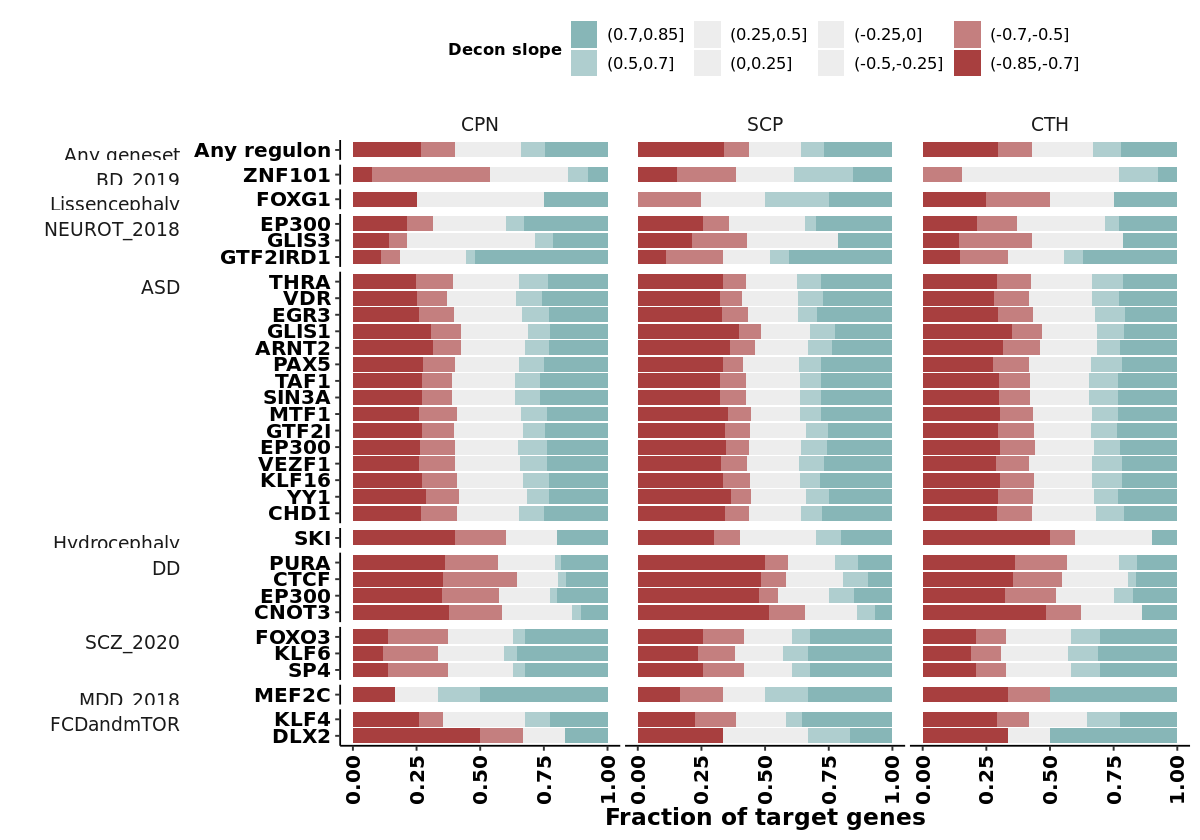

In [15]:
decon.plot <- cat.barplot.regulons(
    RCT = RCT, 
    geneAnnotation = geneAnnotation, meta.colors = meta.colors,
    fill.var = NA,
    fill.label = 'Decon slope',
    v.facets = 'decon',
    orientation='vertical',
    legend.loc = 'top',
)
decon.plot

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'Target'. You can override using the
`.groups` argument.


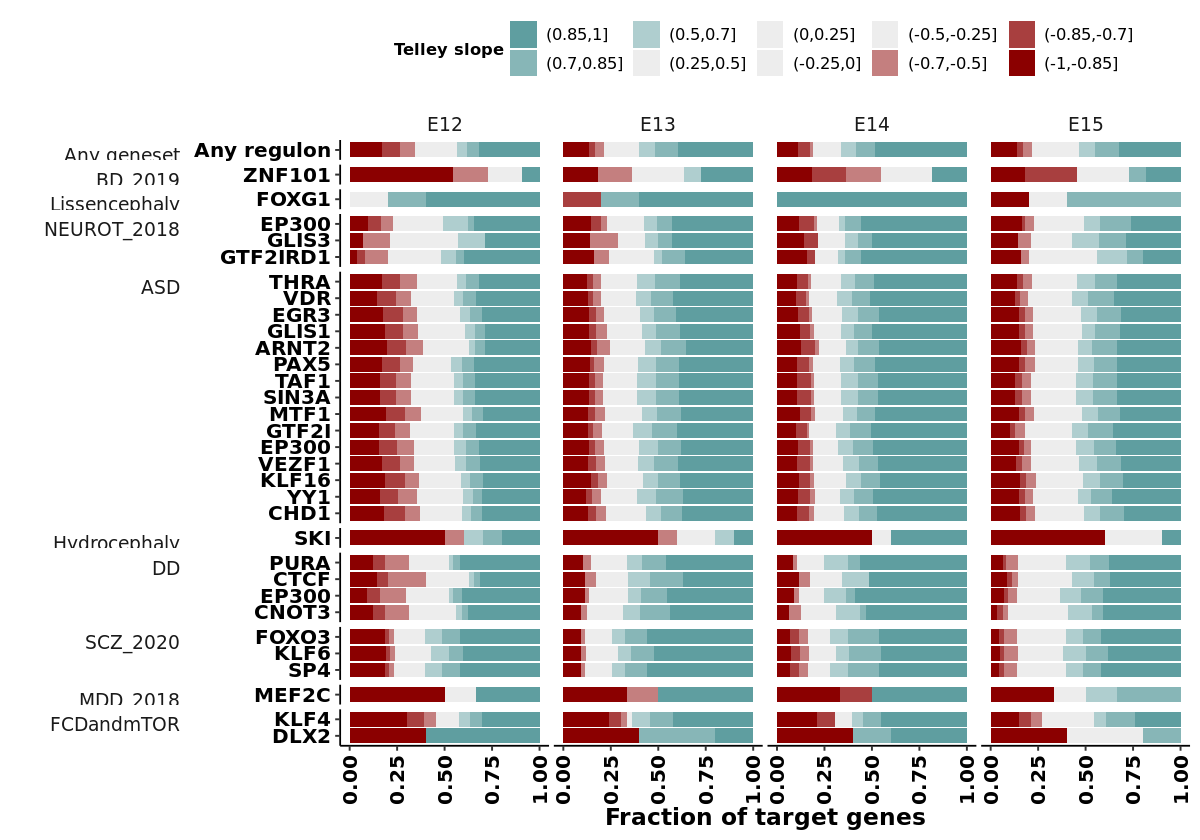

In [16]:
telley.plot <- cat.barplot.regulons(
    RCT = RCT, 
    geneAnnotation = geneAnnotation, meta.colors = meta.colors,
    fill.var = NA,
    fill.label = 'Telley slope',
    v.facets = 'telley',
    orientation='vertical',
    legend.loc = 'top',
)
telley.plot

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'Target'. You can override using the
`.groups` argument.


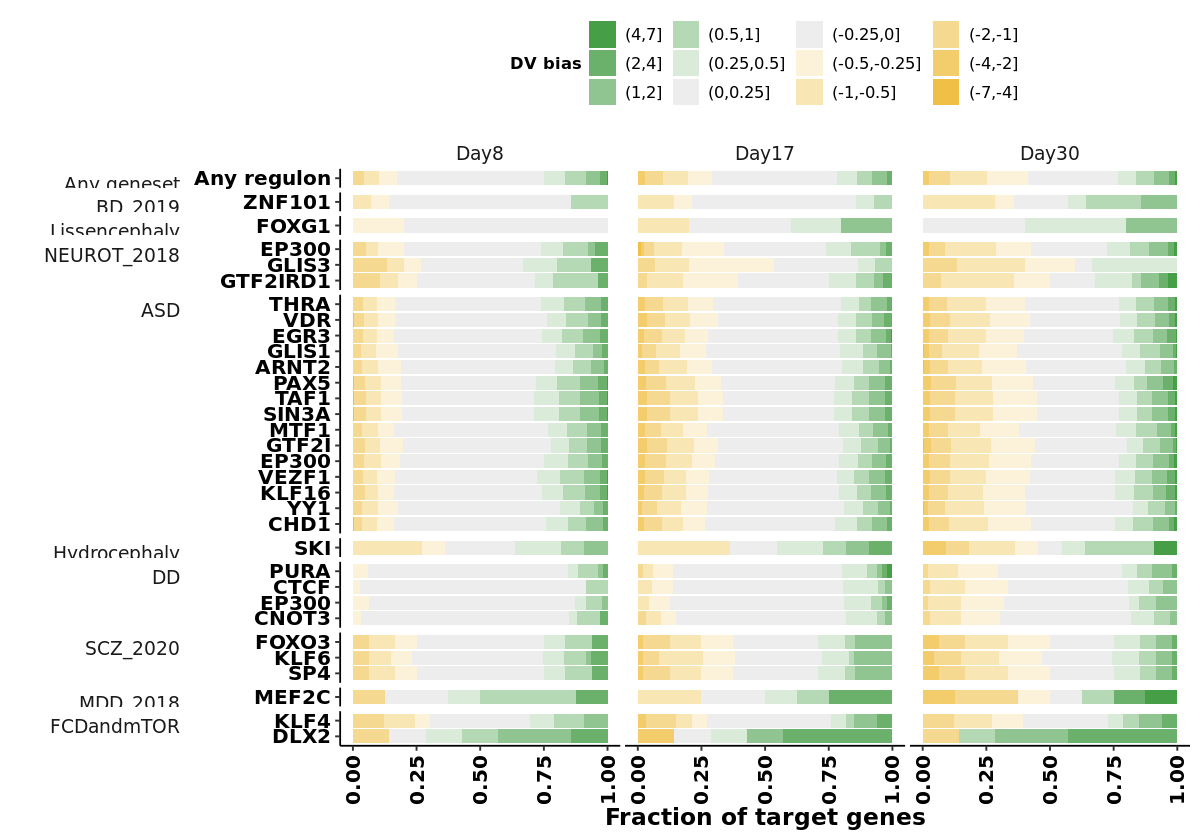

In [17]:
dv.plot <- cat.barplot.regulons(
    RCT = RCT, 
    geneAnnotation = geneAnnotation, meta.colors = meta.colors,
    fill.var = NA,
    fill.label = 'DV bias',
    v.facets = 'dv',
    orientation='vertical',
    legend.loc = 'top',
)
dv.plot

In [22]:
# telley.plot$data %>% arrange(facet, desc(x.axis)) %>% mutate(reg = factor(paste(geneSet, Core), unique(paste(geneSet, Core))))%>% select(fill, reg, vfacet) %>%table

paste(subset(telley.plot$data, (Core == 'FOXG1') & (vfacet == 'E14'))$Target %>% unique(), collapse='", "')

GeneAnnotation[unique(as.character(subset(telley.plot$data, (Core == 'FOXG1'))$Target)), facets$telley]

[1] "CEP85L\", \"DYNC1H1\", \"FKRP\", \"LRP8\", \"VLDLR"

,E12,E13,E14,E15
,<chr>,<chr>,<chr>,<chr>
CEP85L,"(0.7,0.85]","(0.85,1]","(0.85,1]","(0.7,0.85]"
DYNC1H1,"(0,0.25]","(0.85,1]","(0.85,1]","(0.25,0.5]"
FKRP,"(0.85,1]","(-0.85,-0.7]","(0.85,1]","(-1,-0.85]"
LRP8,"(0.85,1]","(0.7,0.85]","(0.85,1]","(0.7,0.85]"
VLDLR,"(0.85,1]","(0.85,1]","(0.85,1]","(0.7,0.85]"


# Fig 4 A
### **Barplot of peak expression sample with number of targets and p-values**

### Sizes

In [62]:
any.sum <- data.frame(
    geneSet='Any geneset',
    Core='Any regulon', 
    n_targets=length(unique(RCT$regulonTbl$Target))
)

In [63]:
sum_count_df <- 
  RCT$regulonTbl %>%
  group_by(geneSet, Core) %>%
  summarise(n_targets = length(unique(Target))) %>%
  rbind(any.sum) %>% 
  mutate(
      x.axis=factor(Core, c('Any regulon', core.levels)),
      facet=factor(geneSet, c('Any geneset', dis.levels))
  )
head(sum_count_df)    

`summarise()` has grouped output by 'geneSet'. You can override using the
`.groups` argument.


geneSet,Core,n_targets,x.axis,facet
<chr>,<chr>,<int>,<fct>,<fct>
ASD,ARNT2,202,ARNT2,ASD
ASD,CHD1,420,CHD1,ASD
ASD,EGR3,455,EGR3,ASD
ASD,EP300,339,EP300,ASD
ASD,GLIS1,241,GLIS1,ASD
ASD,GTF2I,240,GTF2I,ASD


#### Plot

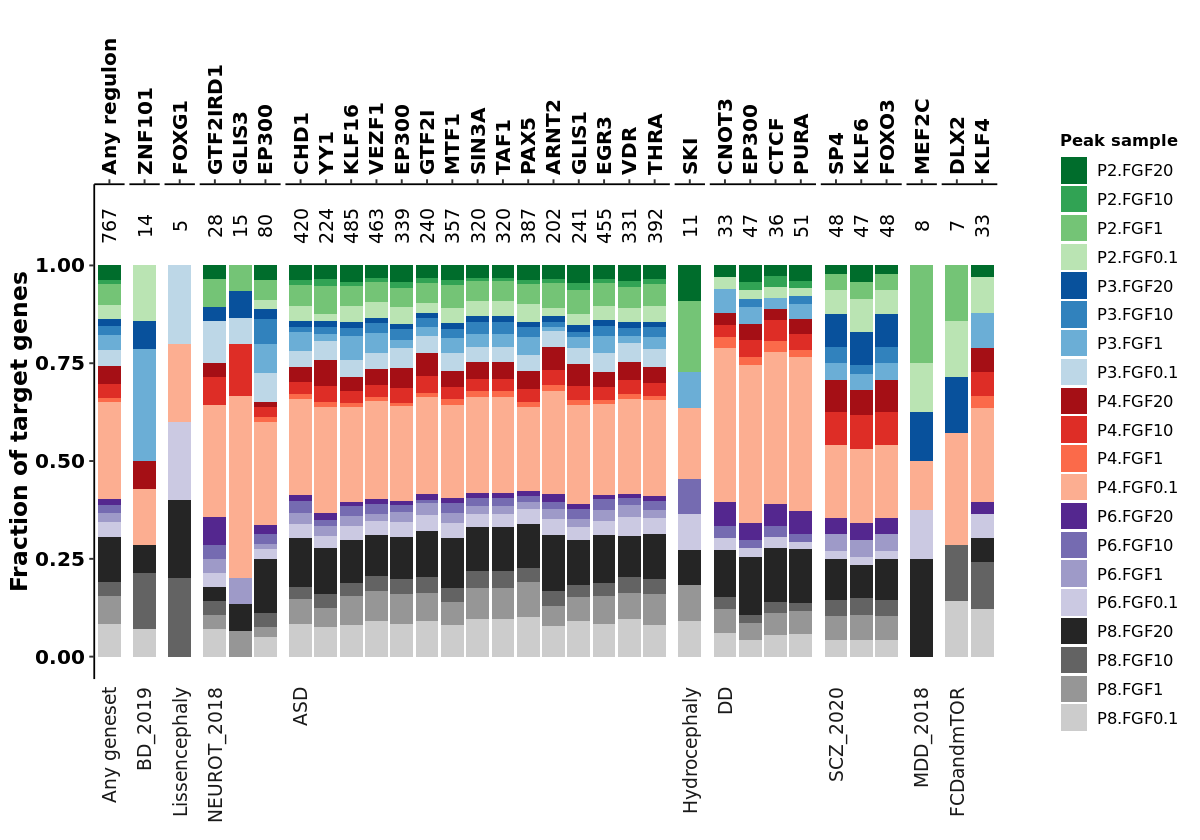

In [64]:
peak.plot.ntargets <- peak.plot +

    geom_text(data=sum_count_df,
              mapping=aes(label=n_targets,
                          y=1.1, 
                          fill=NULL), 
              size=4,
              angle=90) + 

    scale_y_continuous(limits = c(0,1.15), breaks = seq(0,1,0.25))


peak.plot.ntargets

### Core colors and p-values

In [65]:
core.colors <- setNames(
    meta.colors$PeakSample[GeneAnnotation[unique(RCT$regulonTbl$Core), 'PeakSample']], 
    unique(RCT$regulonTbl$Core))
core.colors

ARNT2      CHD1      EGR3     EP300     GLIS1     GTF2I     KLF16      MTF1 
"#756BB1" "#74C476" "#252525" "#FCAE91" "#756BB1" "#FCAE91" "#6BAED6" "#FCAE91" 
     PAX5     SIN3A      TAF1      THRA       VDR     VEZF1       YY1    ZNF101 
"#54278F" "#FCAE91" "#FCAE91" "#969696" "#252525" "#DE2D26" "#74C476" "#08519C" 
    CNOT3      CTCF      PURA      DLX2      KLF4       SKI     FOXG1     MEF2C 
"#6BAED6" "#54278F" "#CCCCCC" "#252525" "#CCCCCC" "#FCAE91" "#08519C" "#252525" 
    GLIS3  GTF2IRD1     FOXO3      KLF6       SP4 
"#BDD7E7" "#6BAED6" "#969696" "#636363" "#BAE4B3"

In [66]:
nperms <- max(sapply(strsplit(colnames(RCT$permutations$perm.df), '.rep', fixed=T), function(x) as.numeric(x[2])))
pvals <- unique(RCT$regulonTblPvals[,c('geneSet', 'Core', 'TFperm_pval.nom')]) %>% 
            mutate(pval=ifelse(TFperm_pval.nom==0,
                               paste0('<', round(1/nperms, 3)), 
                               TFperm_pval.nom))
pvals <- setNames(
    paste0(pvals$Core, ' (', pvals$pval, ')'),
    paste(pvals$geneSet, pvals$Core, sep='|')
)
pvals <- c('Any geneset|Any regulon'='Any regulon', pvals)

#### Plot

In [67]:
gt <- ggplotGrob(peak.plot.ntargets)

gts <- sapply(grep('axis-t', capture.output(gt), value=T), function(x){
    as.numeric(strsplit(x, split=' ', fixed = T)[[1]][1])})
gts_strip <- sapply(grep('strip-b', capture.output(gt), value=T), function(x){
    as.numeric(strsplit(x, split=' ', fixed = T)[[1]][1])})

for (i in c(1:length(gts))){
    
    t <- gts[i]
    
    dis <- gt$grobs[[gts_strip[i]]]$grobs[[1]]$children[[2]]$children[[1]]$label
    genes <- gt$grobs[[t]]$children[[2]]$grobs[[1]]$children[[1]]$label
    
    l <- paste(dis, genes, sep='|')
    if (genes[1] != 'Any regulon'){     
        gt$grobs[[t]]$children[[2]]$grobs[[1]]$children[[1]]$gp$col <- core.colors[genes]
    }
    
    
    # If on top
    gt$grobs[[t]]$children[[2]]$grobs[[1]]$children[[1]]$label <- pvals[l]
}

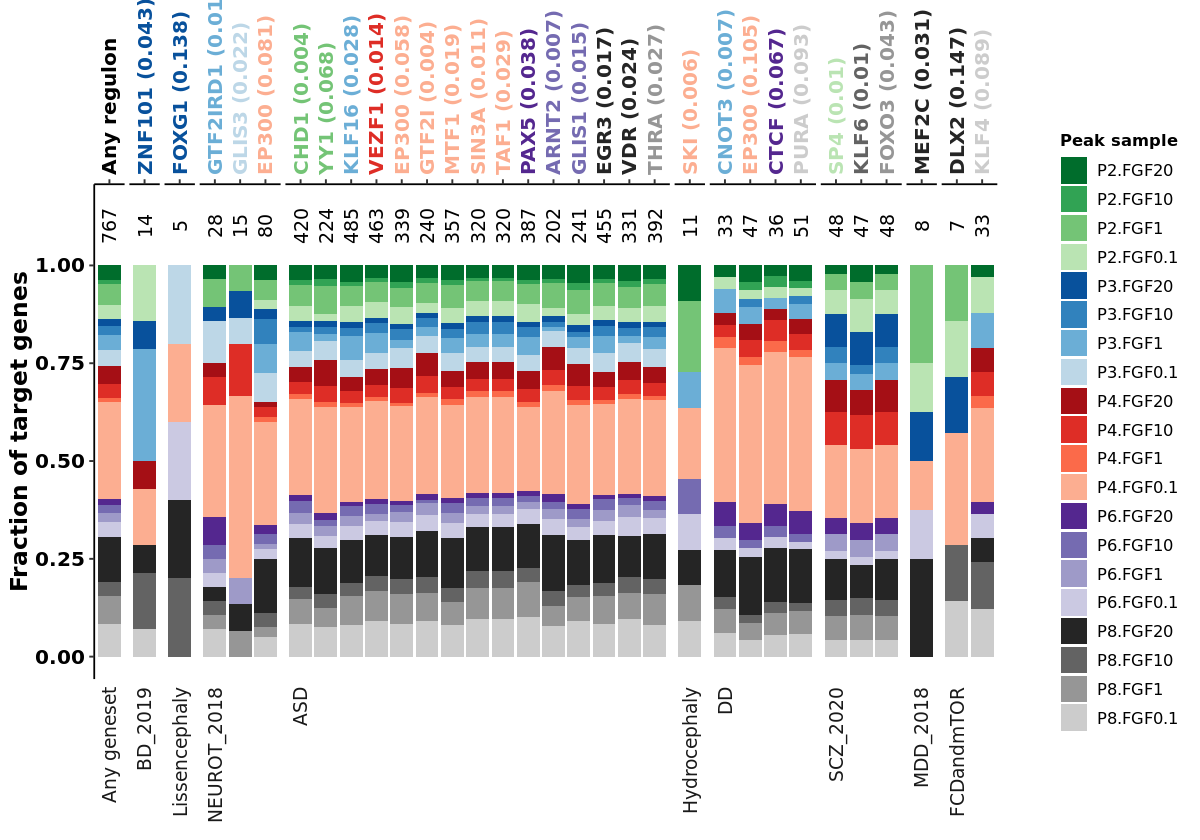

In [68]:
grid::grid.draw(gt)

### Export

In [69]:
pdf('Fig4.A.PeakSampleDistribution.pdf', useDingbats = F, 
    width = 9, height = 6, family='ArialMT')
grid::grid.draw(gt)
dev.off()

png 
  2

# Supp A
### **Combined barplots with number of targets and p-values**

### Modify individual plots

In [70]:
peak.comb <- cat.barplot.regulons(
    RCT = RCT, 
    geneAnnotation = geneAnnotation, meta.colors = meta.colors,
    fill.var = 'PeakSample',
    fill.label = 'Peak sample',
    v.facets = NA,
    orientation='vertical',
    legend.loc = 'top',
) + 
    # Change number of columns
    guides(ncol=5, fill=guide_legend(title.position = 'top')) + 
    theme(
        # Reduce white space
        panel.spacing.x = unit(0, "lines"),
        # Reduce legend space
        legend.key.width= unit(0.4, 'cm'),
        legend.key.height= unit(0.4, 'cm')
    ) + xlab('Peak sample')

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'Target'. You can override using the
`.groups` argument.


In [71]:
decon.comb <- decon.plot  + 
    # Change number of columns
    guides(fill=guide_legend(title.position = 'top')) + 
    theme(
        # Remove x axis text/ticks
        axis.ticks.y = element_blank(), 
        axis.text.y = element_blank(), 
        # Remove facets text
        strip.text.y.left=element_blank(),
        # Reduce white space
        panel.spacing.x = unit(0, "lines"),
        # Reduce legend space
        legend.key.width= unit(0.4, 'cm'),
        legend.key.height= unit(0.4, 'cm')
    ) + xlab('Decon slope')

In [72]:
telley.comb <- telley.plot + 
    # Change number of columns
    guides(fill=guide_legend(title.position = 'top')) + 
    theme(
        # Remove x axis text/ticks
        axis.ticks.y = element_blank(), 
        axis.text.y = element_blank(), 
        # Remove facets text
        strip.text.y.left=element_blank(),
        # Reduce white space
        panel.spacing.x = unit(0, "lines"),
        # Reduce legend space
        legend.key.width= unit(0.4, 'cm'),
        legend.key.height= unit(0.4, 'cm')
    ) + xlab('Telley slope')

In [73]:
dv.comb <- dv.plot  + 
    # Change number of columns
    guides(fill=guide_legend(title.position = 'top')) + 
    theme(
        # Remove x axis text/ticks
        axis.ticks.y = element_blank(), 
        axis.text.y = element_blank(), 
        # Remove facets text
        strip.text.y.left=element_blank(),
        # Reduce white space
        panel.spacing.x = unit(0, "lines"),
        # Reduce legend space
        legend.key.width= unit(0.4, 'cm'),
        legend.key.height= unit(0.4, 'cm')
    ) + xlab('D-V bias') 

### Combine

In [74]:
combined.plot <- cowplot::plot_grid(
    peak.comb, decon.comb, telley.comb, dv.comb,
    ncol = 4,
    rel_widths = c(2.8,2.3,2.3,2.3),
    align = 'h', axis = 'tb')

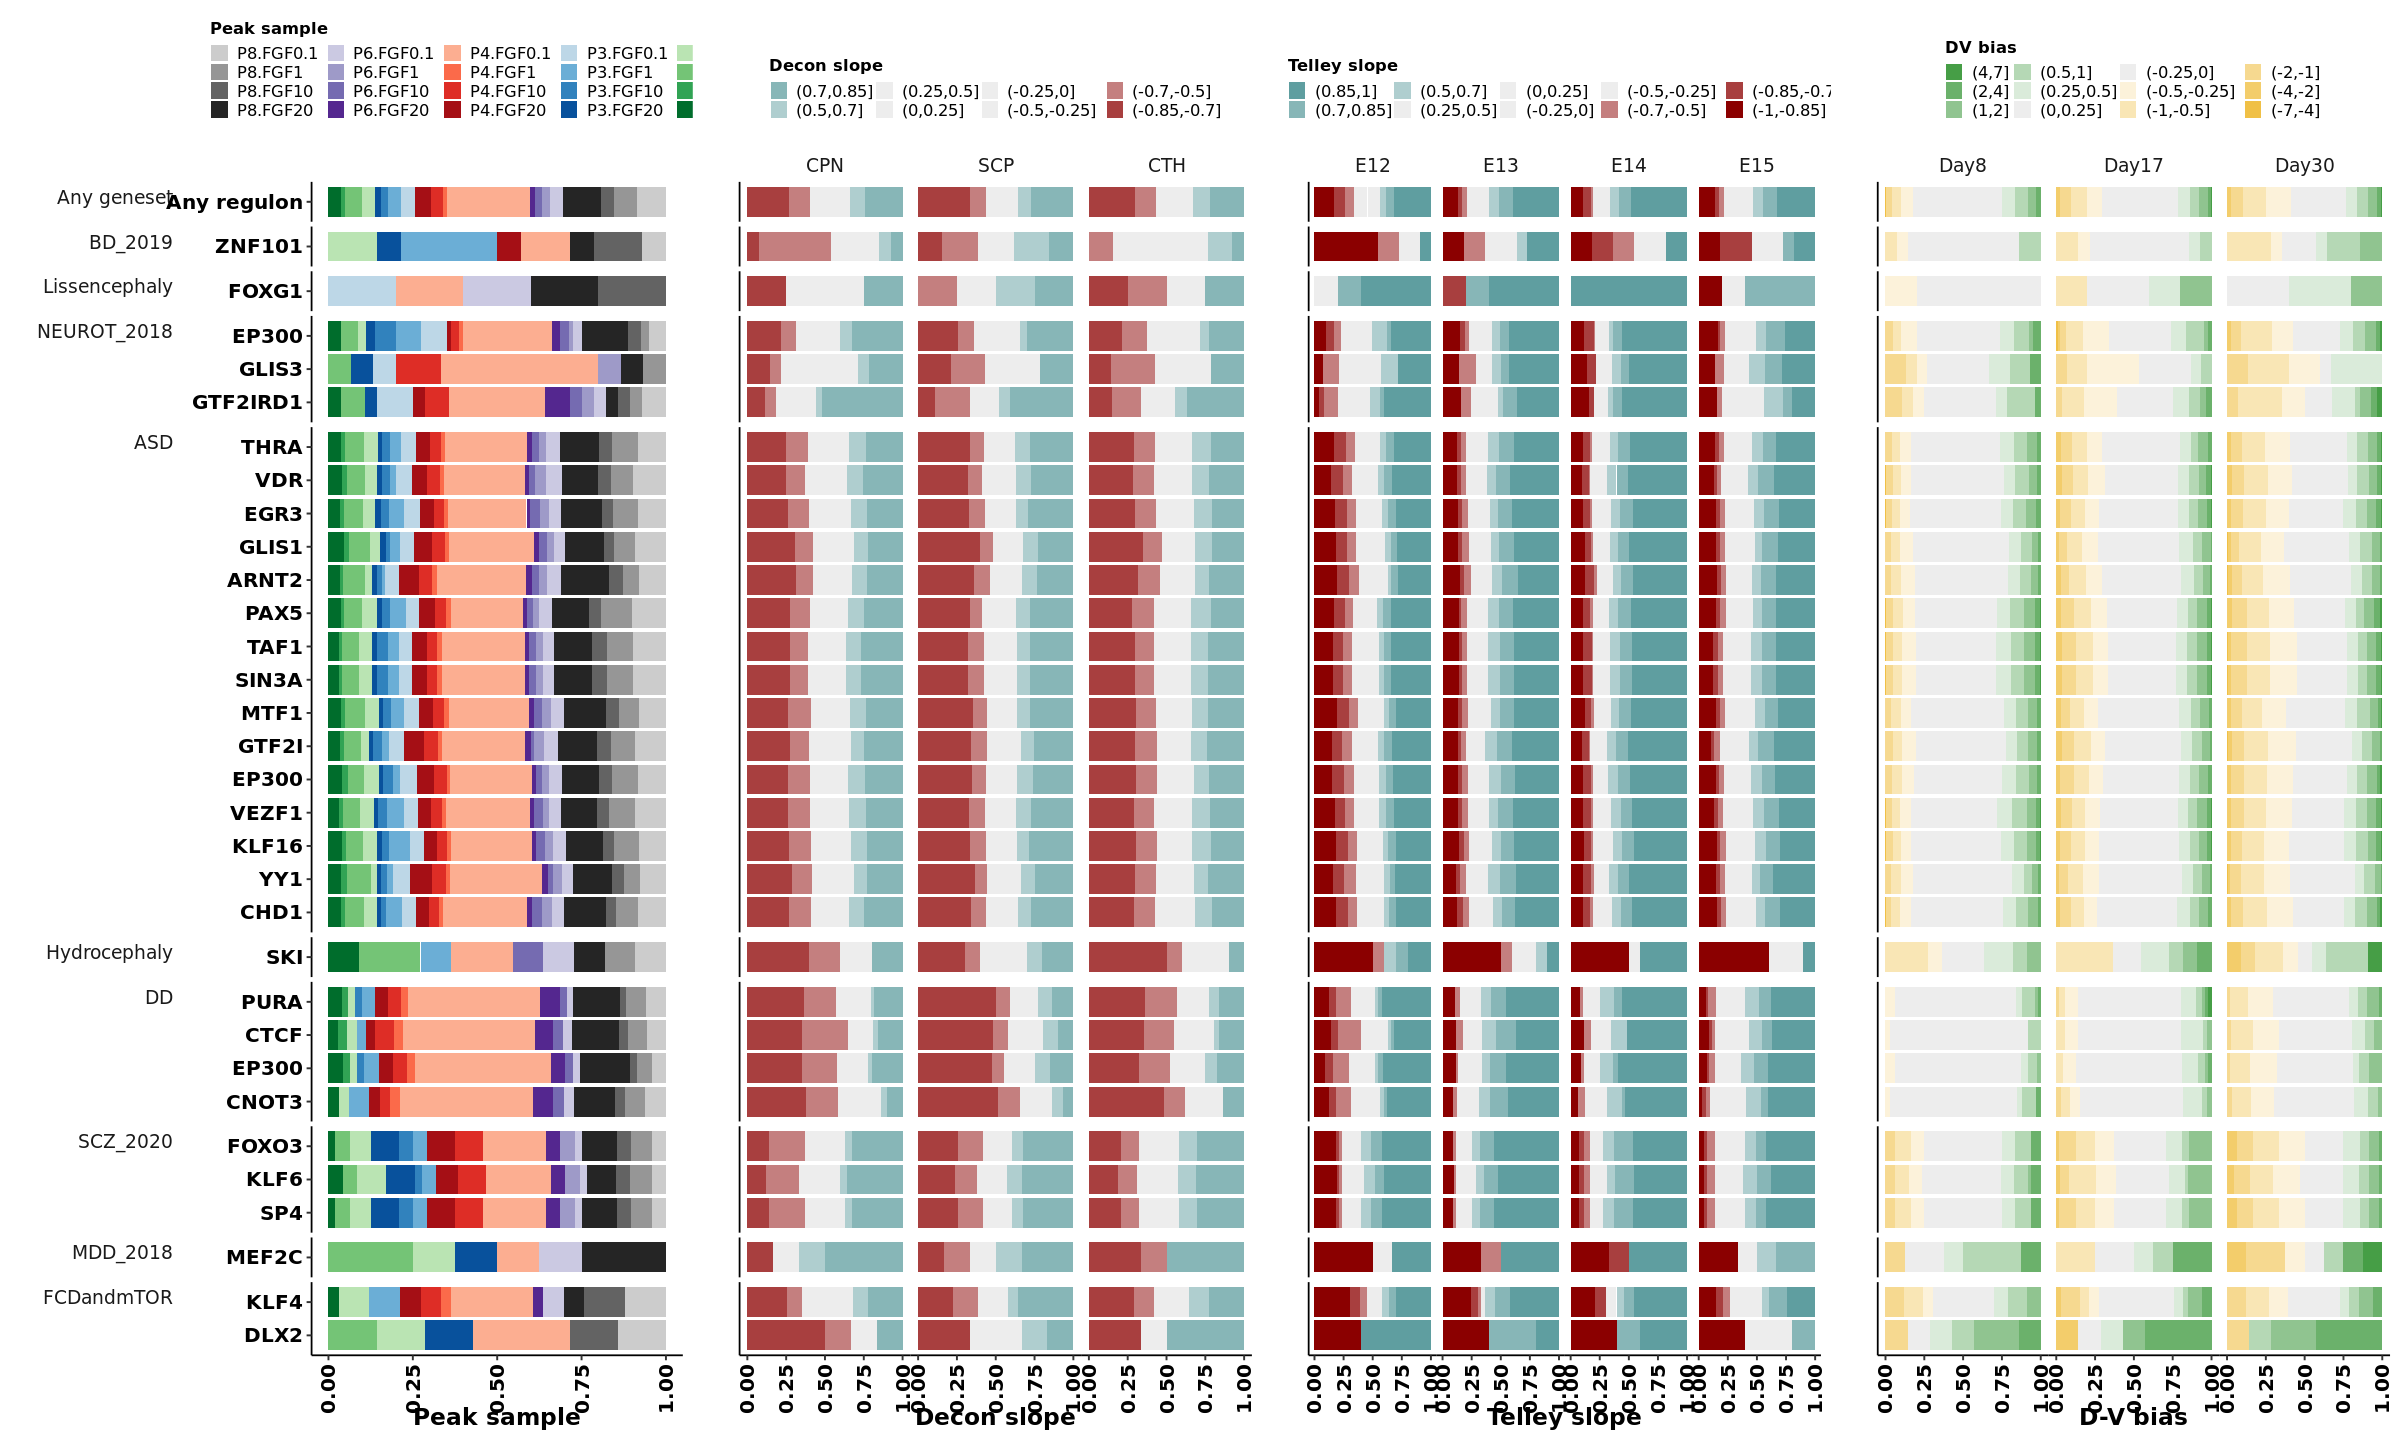

In [75]:
figsize(20,12)
combined.plot

### Export

In [76]:
pdf('Supp.A.TargetDistributions.v3.pdf', 
    useDingbats = F, width=18, height=8)
plot(combined.plot)
dev.off()

png 
  2